# Churn Prediction

## Imports, Settings, and Reproducibility
### Setup for Data, Modeling, and Evaluation
This setup pulls in the core libraries we need for a typical classification workflow. We can load and manipulate data with pandas and NumPy, create consistent plots with Matplotlib and Seaborn, and build a clean train/test pipeline with scikit-learn utilities like splitting and feature scaling. It also brings in a full set of evaluation metrics so we can compare models using accuracy, precision, recall, F1, ROC AUC, and confusion matrices, while keeping results repeatable by fixing a random seed.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Visualization settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Reproducibility
RANDOM_STATE = 42

## Load Dataset
### Load and Preview the Telco Churn Dataset
This code loads the Telco customer churn CSV file into a pandas DataFrame so we can work with it using familiar table operations. We can quickly inspect the first few rows with `head()` to confirm the data loaded correctly, see the available columns, and get an initial feel for the kinds of values we’ll be cleaning and modeling later.

In [2]:
df = pd.read_csv("datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Dataset Dimensions and Structure
### Quick Dataset Size and Structure Check
This code gives us a fast overview of how big the dataset is and what it contains. We can see the number of rows and columns with `shape`, and `info()` helps us understand the column names, data types, and how many non-null values each column has, which is useful for spotting missing data and fields that may need type conversion before modeling.

In [3]:
print("Dataset shape:", df.shape)
df.info()

Dataset shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling

## Summary Statistics
### Summary Statistics for Numeric Features
This code generates descriptive statistics for the dataset’s numeric columns so we can understand the overall distribution of values. We can quickly see measures like the mean, standard deviation, and range, which helps us spot unusual values, potential outliers, and differences in scale that may matter when we build and evaluate machine learning models.

In [4]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## Target Variable Inspection
### Check the Churn Class Balance
This code counts how many customers fall into each churn category and also calculates the same breakdown as proportions. We can use this to understand whether churn is imbalanced in the dataset, which affects how we interpret metrics and may influence choices like evaluation strategy, resampling, or using models and thresholds that handle class imbalance well.

In [5]:
print(df["Churn"].value_counts())

df["Churn"].value_counts(normalize=True)

Churn
No     5174
Yes    1869
Name: count, dtype: int64


Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

## Visualize Target Distribution
### Visualize the Churn Distribution
This code creates a simple bar chart showing how many customers churned versus stayed. We can use this visual check to quickly confirm the class balance we saw in the counts and get an immediate sense of whether churn is relatively rare or common, which helps guide modeling and evaluation decisions.

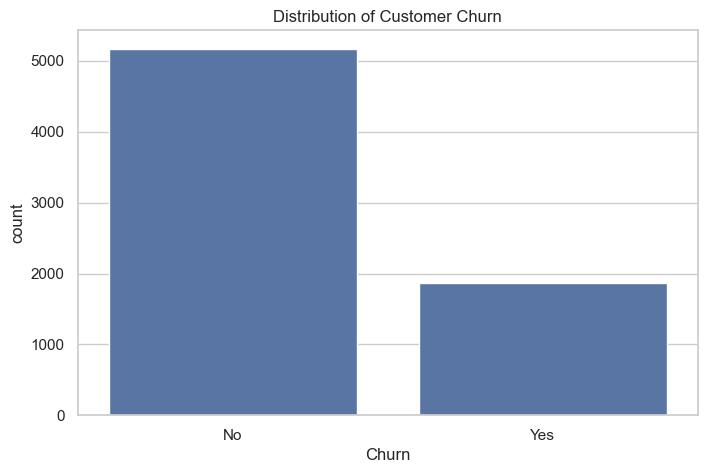

In [6]:
sns.countplot(data=df, x="Churn")
plt.title("Distribution of Customer Churn")
plt.show()

## Check for Missing Values
### Identify Missing Values by Column
This code totals up how many missing values appear in each column and sorts the results so the most affected fields show up first. We can use this to quickly pinpoint where data cleaning or imputation may be needed before we build features and train churn prediction models.

In [7]:
df.isnull().sum().sort_values(ascending=False)

customerID          0
DeviceProtection    0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
OnlineBackup        0
gender              0
OnlineSecurity      0
InternetService     0
MultipleLines       0
PhoneService        0
tenure              0
Dependents          0
Partner             0
SeniorCitizen       0
Churn               0
dtype: int64

## Fix TotalCharges Data Type
### Convert TotalCharges to Numeric and Flag Problem Values
This code forces the `TotalCharges` column into a numeric format so we can use it reliably for analysis and modeling. Any values that can’t be converted are turned into missing values, and the final null count lets us see how many entries became invalid during conversion, which helps us decide how to handle those cases during cleaning.

In [11]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

df["TotalCharges"].isnull().sum()

np.int64(0)

### Remove Missing Rows and Reindex the DataFrame
This code removes any rows that contain missing values so we’re working with a fully complete dataset. After dropping those rows, we reset the index to keep it clean and sequential, and checking `shape` confirms how many records remain for analysis and churn modeling.

In [12]:
df = df.dropna()
df.reset_index(drop=True, inplace=True)

df.shape

(7032, 21)

## Separate Numeric and Categorical Features
### Separate Numeric and Categorical Columns for Preprocessing
This code splits our dataset’s columns into numeric and categorical groups based on their data types. We can use these two lists to apply the right preprocessing steps later, such as scaling numeric features and encoding categorical features, which helps keep the modeling pipeline organized and consistent.

In [13]:
numeric_features = df.select_dtypes(include=["int64", "float64"]).columns
categorical_features = df.select_dtypes(include=["object"]).columns

numeric_features, categorical_features

(Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object'),
 Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
        'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
       dtype='object'))

## Correlation Heatmap
### Correlation Heatmap for Numeric Features
This code computes the correlation matrix for the numeric columns and visualizes it as a heatmap. We can use this to quickly see which numeric features move together, spot potential multicollinearity, and get intuition about relationships that might influence model performance or feature selection.

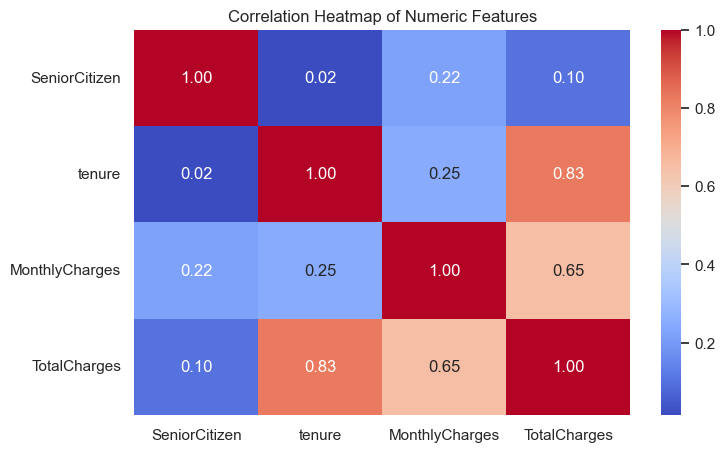

In [14]:
corr = df[numeric_features].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

## Churn Distribution
### Labeled Churn Distribution Plot
This code plots the churn counts again, but with clearer axis labels to match a 0/1 interpretation. We can use this to present the churn imbalance more cleanly in a notebook or report, making it easier to interpret the target variable when discussing results and model performance.

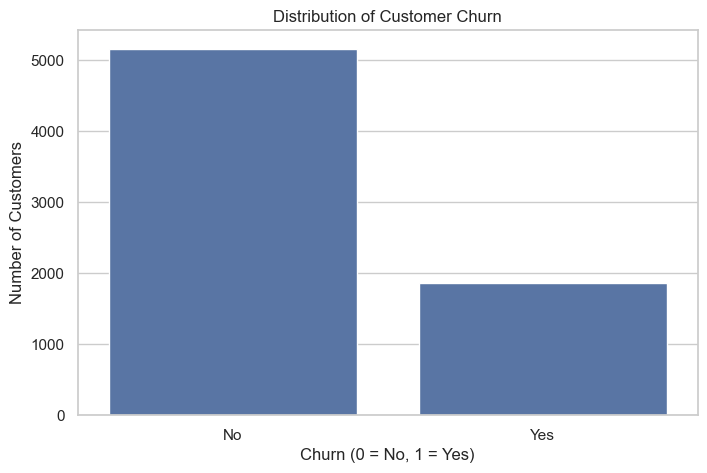

In [15]:
sns.countplot(data=df, x="Churn")
plt.title("Distribution of Customer Churn")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Number of Customers")
plt.show()

## Tenure by Churn Status
### Compare Tenure Distributions by Churn Status
This code uses a boxplot to compare how customer tenure differs between churned and non-churned groups. We can use this view to spot whether churn is associated with shorter or longer customer relationships, and to understand the spread and outliers in tenure that may matter for predicting churn.

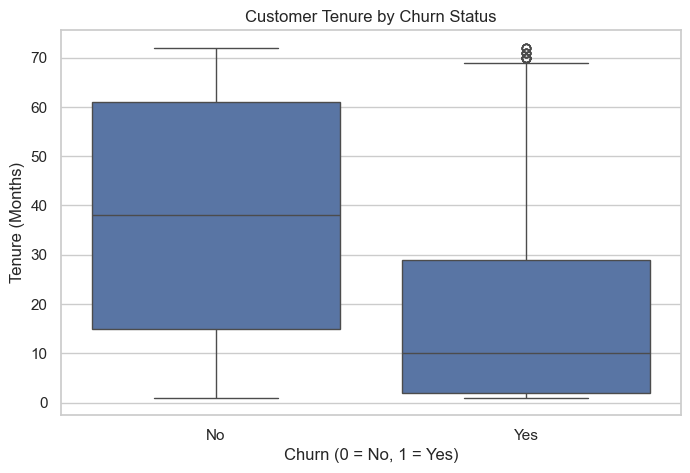

In [16]:
sns.boxplot(data=df, x="Churn", y="tenure")
plt.title("Customer Tenure by Churn Status")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Tenure (Months)")
plt.show()

## Monthly Charges by Churn Status
### Compare Monthly Charges by Churn Status
This code creates a boxplot to show how monthly charges differ between customers who churned and those who stayed. We can use it to see shifts in typical billing amounts, variability, and outliers across the two groups, which helps us judge whether pricing-related patterns may be useful for predicting churn.

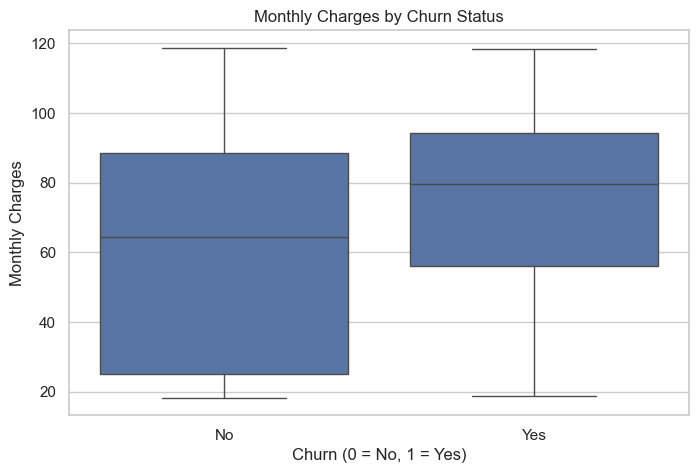

In [17]:
sns.boxplot(data=df, x="Churn", y="MonthlyCharges")
plt.title("Monthly Charges by Churn Status")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Monthly Charges")
plt.show()

## Churn Rate by Contract Type
### Convert Churn to 0/1 and Plot Churn Rate by Contract Type
This code makes sure the target column is numeric by mapping churn labels to 0 and 1, which lets us compute churn rates as simple averages. We can then group customers by contract type to compare average churn across contracts, and visualize the results in a bar chart to highlight which contract terms are associated with higher or lower churn.

Churn
0    5163
1    1869
Name: count, dtype: int64


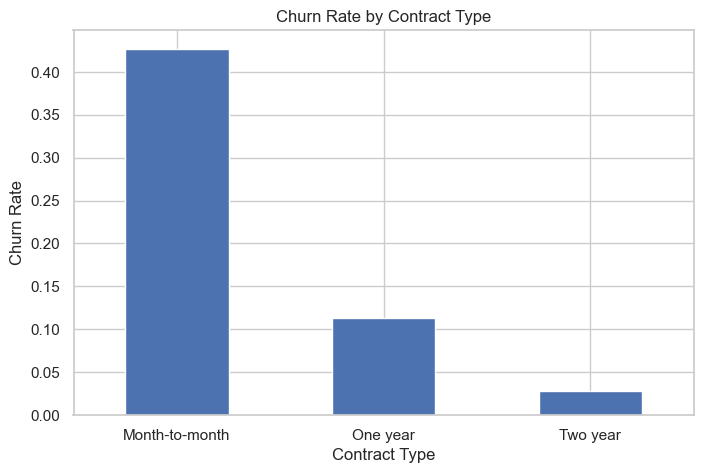

In [19]:
# Ensure Churn is numeric (0/1) for rate calculations
if df["Churn"].dtype == "object":
    df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

print(df["Churn"].value_counts())

contract_churn = df.groupby("Contract")["Churn"].mean().sort_values(ascending=False)

contract_churn.plot(kind="bar")
plt.title("Churn Rate by Contract Type")
plt.ylabel("Churn Rate")
plt.xlabel("Contract Type")
plt.xticks(rotation=0)
plt.show()

## Churn Rate by Payment Method
### Plot Churn Rate by Payment Method
This code calculates the average churn rate for each payment method by grouping customers and taking the mean of the 0/1 churn indicator. We can use the horizontal bar chart to quickly compare which payment methods are linked to higher churn and which are linked to lower churn, helping us identify behavioral patterns that may be predictive.

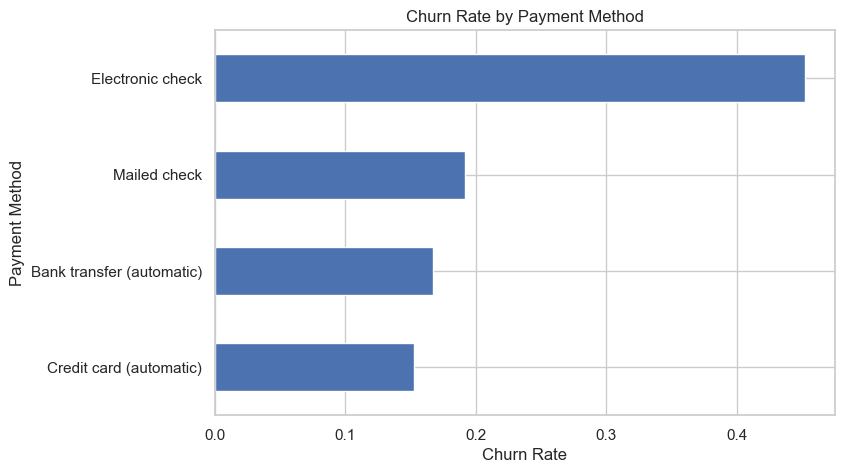

In [20]:
payment_churn = df.groupby("PaymentMethod")["Churn"].mean().sort_values()

payment_churn.plot(kind="barh")
plt.title("Churn Rate by Payment Method")
plt.xlabel("Churn Rate")
plt.ylabel("Payment Method")
plt.show()

## Internet Service Type vs Churn
### Churn Rate by Internet Service Type
This code plots the average churn rate for each internet service category using a bar chart, where the mean of the 0/1 churn label represents the churn rate. We can use this to quickly compare how churn differs across service types and spot categories that may be more strongly associated with customers leaving.

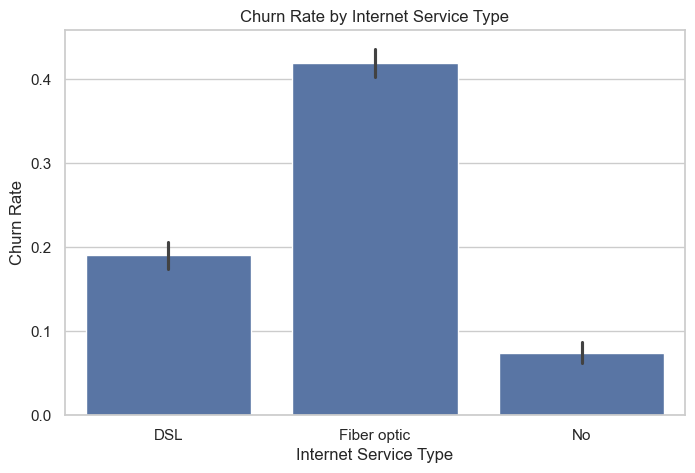

In [21]:
sns.barplot(data=df, x="InternetService", y="Churn")
plt.title("Churn Rate by Internet Service Type")
plt.ylabel("Churn Rate")
plt.xlabel("Internet Service Type")
plt.show()

## Encode Target
### Ensure Churn is a Numeric Target Variable
This code double-checks that the `Churn` column is encoded as 0 and 1 instead of text labels, which keeps our modeling and metric calculations consistent. We can confirm the final class counts with `value_counts()` to make sure the mapping worked as expected.

In [22]:
# Ensure target is numeric
if df["Churn"].dtype == "object":
    df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

df["Churn"].value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64

## One-Hot Encode Categorical Features
### Prepare Features and One-Hot Encode Categorical Variables
This code separates the churn target from the input features and removes the customer ID since it’s an identifier rather than a predictive feature. We then one-hot encode the categorical columns so our models can work with numeric inputs, using `drop_first=True` to reduce redundancy in the encoded categories. Checking the resulting shape confirms how many feature columns we have after encoding.

In [23]:
X = df.drop(columns=["Churn", "customerID"])
y = df["Churn"]

X_encoded = pd.get_dummies(X, drop_first=True)

X_encoded.shape

(7032, 30)

## Train / Test Split
### Split Data into Stratified Train and Test Sets
This code divides our encoded feature matrix and churn labels into training and testing subsets so we can fit models on one portion and evaluate on unseen data. Using `stratify=y` keeps the churn proportion consistent in both splits, and setting a fixed random state makes the split reproducible. The printed shapes confirm the sample sizes allocated to training and testing.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape

((5274, 30), (1758, 30))

## Feature Scaling
### Standardize Features for Model Training
This code scales our training features to have a consistent mean and variance, which helps models like logistic regression behave more reliably when predictors are on different scales. We fit the scaler only on the training data and apply the same transformation to the test data, keeping the evaluation fair and preventing information from the test set from leaking into training.

In [25]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression
### Train Logistic Regression and Generate Predictions
This code trains a logistic regression classifier on the scaled training data to model the probability of customer churn. We can use the fitted model to produce both class predictions for the test set and churn probabilities, which are useful for threshold tuning and for metrics like ROC AUC that depend on probability scores rather than hard labels.

In [26]:
log_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

## Logistic Regression Evaluation
### Evaluate Logistic Regression with Multiple Classification Metrics
This code calculates a set of key performance metrics for our logistic regression model using the test labels and both predicted classes and probabilities. We can compare overall correctness with accuracy, focus on churn detection quality with precision and recall, balance them with F1 score, and measure ranking performance with ROC AUC. Wrapping the results into a DataFrame makes the metrics easy to read and compare against other models later.

In [27]:
lr_results = {
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr),
    "Recall": recall_score(y_test, y_pred_lr),
    "F1 Score": f1_score(y_test, y_pred_lr),
    "ROC AUC": roc_auc_score(y_test, y_prob_lr),
}

pd.DataFrame(lr_results, index=["Logistic Regression"])

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,0.807736,0.656934,0.578158,0.615034,0.840007


## Decision Tree Model
### Train a Decision Tree and Produce Predictions
This code fits a decision tree classifier on the training data to learn rule-based splits that predict churn. We can generate both class predictions and churn probabilities on the test set, which lets us evaluate the model with standard classification metrics and probability-based measures like ROC AUC.

In [28]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

### Evaluate the Decision Tree Model
This code summarizes how well the decision tree performs on the test set by computing accuracy, precision, recall, F1 score, and ROC AUC. We can use these metrics to compare the tree against other models and understand its trade-offs, such as whether it catches more churners (recall) at the cost of more false alarms (precision).

In [29]:
dt_results = {
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision": precision_score(y_test, y_pred_dt),
    "Recall": recall_score(y_test, y_pred_dt),
    "F1 Score": f1_score(y_test, y_pred_dt),
    "ROC AUC": roc_auc_score(y_test, y_prob_dt),
}

pd.DataFrame(dt_results, index=["Decision Tree"])

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Decision Tree,0.725825,0.48497,0.518201,0.501035,0.659379


## Random Forest Model
### Train a Random Forest and Generate Churn Predictions
This code trains a random forest model by building many decision trees and combining their outputs to improve stability and predictive performance. We can use the fitted ensemble to predict churn classes and estimate churn probabilities on the test set, giving us both discrete predictions for standard metrics and probability scores for ROC AUC and threshold-based analysis.

In [30]:
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

### Evaluate the Random Forest Model
This code computes a consistent set of classification metrics for the random forest using the test labels, predicted classes, and predicted probabilities. We can use the resulting table to compare the random forest’s performance against earlier models and see whether the ensemble improves the balance of precision, recall, F1 score, and ROC AUC.

In [31]:
rf_results = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1 Score": f1_score(y_test, y_pred_rf),
    "ROC AUC": roc_auc_score(y_test, y_prob_rf),
}

pd.DataFrame(rf_results, index=["Random Forest"])

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Random Forest,0.790671,0.635616,0.496788,0.557692,0.817034


## Gradient Boosting Model
### Train Gradient Boosting and Predict Churn
This code fits a gradient boosting classifier, which builds an ensemble of shallow trees sequentially so each new tree focuses on correcting the errors of the previous ones. We can use the trained model to generate both churn class predictions and churn probabilities on the test set, enabling strong comparisons using standard metrics and probability-based evaluation like ROC AUC.

In [32]:
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]

### Evaluate the Gradient Boosting Model
This code calculates the same set of evaluation metrics for gradient boosting that we used for the other classifiers, using both predicted labels and predicted probabilities. Putting the results into a DataFrame helps us compare gradient boosting side-by-side with logistic regression, decision trees, and random forests to see which model best captures churn while balancing precision and recall.

In [33]:
gb_results = {
    "Accuracy": accuracy_score(y_test, y_pred_gb),
    "Precision": precision_score(y_test, y_pred_gb),
    "Recall": recall_score(y_test, y_pred_gb),
    "F1 Score": f1_score(y_test, y_pred_gb),
    "ROC AUC": roc_auc_score(y_test, y_prob_gb),
}

pd.DataFrame(gb_results, index=["Gradient Boosting"])

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Gradient Boosting,0.799204,0.646907,0.537473,0.587135,0.842384


## Model Comparison Table
### Compare Model Performance in a Single Table
This code combines the metric summaries from all four models into one DataFrame, aligning accuracy, precision, recall, F1 score, and ROC AUC side-by-side. We can use this consolidated view to quickly identify which classifier performs best overall and which one offers the best trade-offs for churn prediction.

In [34]:
model_comparison = pd.concat(
    [
        pd.DataFrame(lr_results, index=["Logistic Regression"]),
        pd.DataFrame(dt_results, index=["Decision Tree"]),
        pd.DataFrame(rf_results, index=["Random Forest"]),
        pd.DataFrame(gb_results, index=["Gradient Boosting"]),
    ]
)

model_comparison

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,0.807736,0.656934,0.578158,0.615034,0.840007
Decision Tree,0.725825,0.484970,0.518201,0.501035,0.659379
Random Forest,0.790671,0.635616,0.496788,0.557692,0.817034
Gradient Boosting,0.799204,0.646907,0.537473,0.587135,0.842384


### 1\. Overall performance pattern

All models achieve accuracy close to 80%, which indicates that customer churn can be predicted reasonably well using the available features. However, accuracy alone is not sufficient because the dataset is imbalanced, making precision, recall, and ROC-AUC more informative for evaluating model effectiveness.

### 2\. Logistic Regression (Best baseline, strong interpretability)

*   **Accuracy:** 0.81 (highest)
    
*   **ROC-AUC:** 0.84
    
*   **Recall:** 0.58 (highest among all models)
    

Logistic Regression performs surprisingly well and achieves the **best recall**, meaning it identifies churned customers more effectively than the other models. This makes it particularly valuable for business use cases where missing a churned customer is costly. Its interpretability also makes it attractive for explaining model decisions to stakeholders.

### 3\. Decision Tree (Weakest performer)

*   Lowest scores across all metrics
    
*   Likely overfits the training data
    

The decision tree performs noticeably worse than the other models, particularly in ROC-AUC (0.66). This suggests that a single tree is insufficient to capture the complexity of churn behavior.

### 4\. Random Forest (Stable but conservative)

*   **ROC-AUC:** 0.82
    
*   Lower recall (0.50)
    

The random forest improves over the decision tree but shows reduced recall, meaning it is more conservative in predicting churn. This can be problematic if the business goal is early churn detection.

### 5\. Gradient Boosting (Best overall discrimination)

*   **Highest ROC-AUC:** 0.84
    
*   Balanced precision and recall
    

Gradient Boosting achieves the highest ROC-AUC, indicating strong overall discrimination between churned and non-churned customers. While its recall is slightly lower than logistic regression, it offers a strong balance between performance and robustness.

## ROC Curve Comparison for All Models
### Plot and Compare ROC Curves Across Models
This code computes the ROC curve for each classifier using the predicted churn probabilities, then calculates the AUC to summarize how well each model separates churners from non-churners across all possible thresholds. We can visualize the curves on one chart to compare models in terms of sensitivity versus false alarms, with the diagonal line providing a random-guess baseline for context.

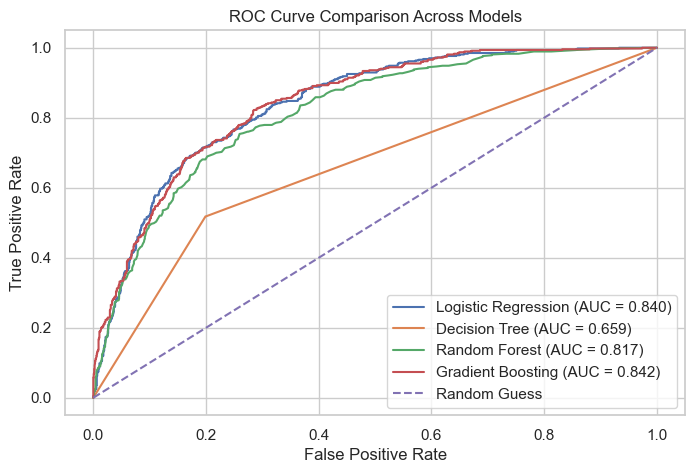

In [35]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curves and AUC for each model
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)

auc_lr = auc(fpr_lr, tpr_lr)
auc_dt = auc(fpr_dt, tpr_dt)
auc_rf = auc(fpr_rf, tpr_rf)
auc_gb = auc(fpr_gb, tpr_gb)

# Plot ROC curves
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {auc_gb:.3f})")

# Baseline
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Guess")

plt.title("ROC Curve Comparison Across Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

### Overall takeaway

All models perform better than random guessing, indicating meaningful predictive signal in the data. However, the separation between curves clearly shows differences in each model's ability to distinguish churned from non-churned customers.

### Model-by-model interpretation

*   **Gradient Boosting (AUC ≈ 0.84)** achieves the highest curve overall, confirming it provides the strongest discrimination. This aligns with its top ROC-AUC score in the comparison table.
    
*   **Logistic Regression (AUC ≈ 0.84)** performs nearly as well, with a curve that closely tracks gradient boosting across most thresholds. This reinforces its value as a strong and interpretable baseline.
    
*   **Random Forest (AUC ≈ 0.82)** performs well but consistently below the top two models, indicating slightly weaker discrimination.
    
*   **Decision Tree (AUC ≈ 0.66)** shows the weakest performance, staying much closer to the random guess line, which confirms it is not suitable as a final model.

## Confusion Matrix – Logistic Regression
### Confusion Matrix Heatmap for Logistic Regression
This code builds a confusion matrix from the logistic regression test predictions and visualizes it as a labeled heatmap. We can use it to see how many customers were correctly classified as churn or no churn, and where the model makes mistakes through false positives and false negatives, which helps interpret performance beyond summary metrics.

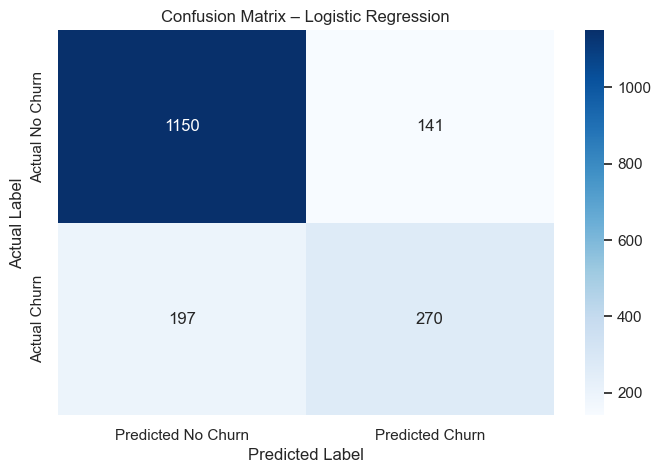

In [36]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

sns.heatmap(
    cm_lr,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted No Churn", "Predicted Churn"],
    yticklabels=["Actual No Churn", "Actual Churn"],
)

plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

## Confusion Matrix – Gradient Boosting
### Confusion Matrix Heatmap for Gradient Boosting
This code generates a confusion matrix for the gradient boosting model and displays it as a heatmap with clear labels for predicted versus actual churn outcomes. We can use this to understand exactly how the model’s correct predictions and errors are distributed, especially the balance between missed churners and false churn alarms, which is often more actionable than a single metric alone.

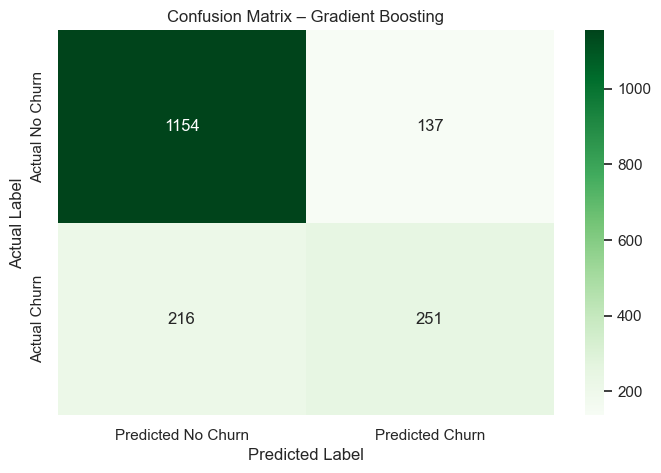

In [37]:
cm_gb = confusion_matrix(y_test, y_pred_gb)

sns.heatmap(
    cm_gb,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Predicted No Churn", "Predicted Churn"],
    yticklabels=["Actual No Churn", "Actual Churn"],
)

plt.title("Confusion Matrix – Gradient Boosting")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

## Classification Reports
### Detailed Classification Reports for Logistic Regression and Gradient Boosting
This code prints classification reports for both logistic regression and gradient boosting so we can inspect precision, recall, and F1 score for each class, along with overall averages. We can use these reports to see how each model performs specifically on churners versus non-churners, making it easier to understand trade-offs that may be hidden by a single aggregate metric.

In [38]:
print("Logistic Regression Classification Report\n")
print(classification_report(y_test, y_pred_lr))

print("\nGradient Boosting Classification Report\n")
print(classification_report(y_test, y_pred_gb))

Logistic Regression Classification Report

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1291
           1       0.66      0.58      0.62       467

    accuracy                           0.81      1758
   macro avg       0.76      0.73      0.74      1758
weighted avg       0.80      0.81      0.80      1758


Gradient Boosting Classification Report

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1291
           1       0.65      0.54      0.59       467

    accuracy                           0.80      1758
   macro avg       0.74      0.72      0.73      1758
weighted avg       0.79      0.80      0.79      1758



## Confusion Matrix Interpretation

### Logistic Regression

From the confusion matrix:

* **True Negatives (No Churn correctly predicted):** 1150
* **False Positives (Predicted churn, actually stayed):** 141
* **False Negatives (Missed churners):** 197
* **True Positives (Correctly predicted churn):** 270

This model correctly identifies **about 58% of churned customers**, which aligns with its higher recall score. While it produces slightly more false positives, it misses fewer churners compared to gradient boosting. This makes logistic regression suitable for early warning systems where identifying at-risk customers is prioritized over minimizing false alarms.

### Gradient Boosting

From the confusion matrix:

* **True Negatives:** 1154
* **False Positives:** 137
* **False Negatives:** 216
* **True Positives:** 251

Gradient boosting produces **fewer false positives** than logistic regression but misses more churned customers. This reflects its lower recall but more conservative predictions. The model focuses on stronger signals before labeling a customer as at risk.

## Classification Report Insights

### Churn Class (1 = Churn)

| Model               | Precision | Recall   | F1       |
| ------------------- | --------- | -------- | -------- |
| Logistic Regression | 0.66      | **0.58** | **0.62** |
| Gradient Boosting   | 0.65      | 0.54     | 0.59     |

* Logistic regression **captures more churners**
* Gradient boosting is **slightly more conservative**
* Overall accuracy is similar (~80%)